In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast, joblib
from gensim.models import Word2Vec,KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support, accuracy_score
plt.rcParams["figure.figsize"] = (10,10)
numero = 2
path = '../Salida/Flujo{num}/SOCI/'.format(num = numero)

In [3]:
def enumerate_dimensions(dimension, list_dimensions):
    return list_dimensions.index(dimension)

def make_feature_vec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model[word])
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

def get_avg_feature_vecs(reviews, model, num_features):
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

df = pd.read_csv('../../Data/Flujo{num}.csv'.format(num=numero), sep=";")
model = Word2Vec.load('../../modelWord2vec_flujo{num}.bin'.format(num=numero))
df = df[df.Area == 'Social Interno']
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)

list_responses = np.array(df.Respuesta)
list_dimensions = np.array(df._dimension)
num_features = 10
list_responses_vec = get_avg_feature_vecs(list_responses, model, num_features)

<ipython-input-3-9f8f9bfbc8b2>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vec = np.add(feature_vec,model[word])


In [4]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
for valores_entrenamiento, valores_testeo in kf.split(list_responses_vec):
    print("paso k")
    x_train = list_responses_vec[valores_entrenamiento]
    x_test = list_responses_vec[valores_testeo]
    y_train = list_dimensions[valores_entrenamiento]
    y_test = list_dimensions[valores_testeo]
    
    forest = RandomForestClassifier(n_jobs=3, oob_score = True, max_depth=9, n_estimators=1000, bootstrap = True)
    history = forest.fit(x_train , y_train)
    predictions = forest.predict(x_test)
    
    score = accuracy_score(y_test ,predictions)
    medidas = precision_recall_fscore_support(y_test, predictions)
    resultados.append([score, medidas])
    
joblib.dump(forest, path+'model.pkl')

paso k
paso k
paso k
paso k
paso k
paso k
paso k
paso k
paso k
paso k


['../Salida/Flujo2/SOCI/model.pkl']

In [5]:
print("acurracy mean",np.array([res[0] for res in resultados]).mean())
print("media precision",np.array([np.array([res[1][0][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[1][1][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[1][2][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[1][3][i] for res in resultados]).mean() for i in range(num_classes)]).mean())

acurracy mean 0.5725019290437724
media precision 0.5381249383714406
media recall 0.5060748654748977
media fscore 0.5060015092121675
media support 570.8666666666667


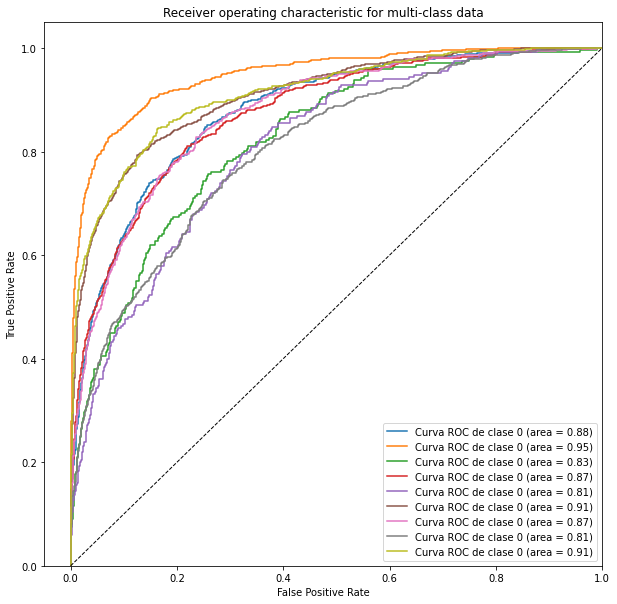

In [6]:
plt.clf() 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.colors as mcolors
plt.rcParams["figure.figsize"] = (10,10)

y_test_bin = label_binarize(y_test, classes=range(num_classes))
y_predic_bin = forest.predict_proba(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_predic_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
dict_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['#000000','#800000', '#FF00FF','#000080', '#00FFFF']
colors = cycle(dict_colors)
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='Curva ROC de clase {0} (area = {1:0.2f})'
             ''.format(list_dimensions[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(path+"ROC.png")